# TODO
- ogarnac dbscan
- moze jeszcze cos z feature engineeringiem ale chyba nie trzeba


In [187]:
import pandas as pd
import numpy as np
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import random

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN,MiniBatchKMeans
from sklearn import  mixture

from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler,RobustScaler, Normalizer

from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score

import re
# pip install nltk
import nltk
from collections import defaultdict

nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\natal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\natal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# data preparation

after tests we have decided to do some changes

we are going to apply pca with 5 components to reduce number of unnecessary variables

we also delete streams charts and plylists since these variables dont influence clustering in positive way

cyclical key encoding doesnt work

In [188]:
def split_artists(df, artist_col='artist(s)_name'):
    df_expanded = df.copy()
    df_expanded[artist_col] = df_expanded[artist_col].str.split(',')
    df_expanded = df_expanded.explode(artist_col)
    df_expanded[artist_col] = df_expanded[artist_col].str.lower().str.replace(' ', '')
    return df_expanded.reset_index(drop=True)
def calculate_mean_streams(df, artist_col='artist(s)_name', streams_col='streams'):
    mean_streams = df.groupby(artist_col)[streams_col].mean()
    return mean_streams.to_dict()
def process_artists(df, artist_avg_streams, artist_col='artist(s)_name', artist_count_col='artist_count'):
    def get_top_artist(artists, artist_avg_streams):
        artists = [artist.lower().replace(' ', '') for artist in artists]
        valid_artists = [artist for artist in artists if artist in artist_avg_streams]
        if valid_artists:
            top_artist = max(valid_artists, key=lambda artist: artist_avg_streams[artist])
        else:
            top_artist = random.choice(artists)
        return top_artist
    processed_df = df.copy()
    for i, row in processed_df.iterrows():
        artists = row[artist_col].split(',')
        top_artist = get_top_artist(artists, artist_avg_streams)
        processed_df.at[i, artist_col] = top_artist
            
    return processed_df
def assign_artist_popularity(df, artist_avg_streams, artist_col='artist(s)_name'):
    # Calculate the four quantiles for the dictionary values
    quantiles = pd.qcut(list(artist_avg_streams.values()), 4, labels=False, retbins=True)[1]
    
    # Function to assign popularity based on quantiles
    def get_popularity(artist, artist_avg_streams, quantiles):
        artist = artist.lower().replace(' ', '')
        avg_streams = artist_avg_streams.get(artist, None)
        if avg_streams is not None:
            if avg_streams <= quantiles[1]:
                return 1
            elif avg_streams <= quantiles[2]:
                return 2
            elif avg_streams <= quantiles[3]:
                return 3
            else:
                return 4
        else:
            return 1  # Assign 1 if artist is not in the dictionary
    
    # Create a new column 'artist_popularity' and assign values based on quantiles
    df['artist_popularity'] = df[artist_col].apply(lambda artist: get_popularity(artist, artist_avg_streams, quantiles))
    
    return df


In [189]:
# Changed function
def preprocess_data(df):
    
    # handle incorrect data ande missing values
    non_numeric_indexes = df[df['streams'].astype(str).str.contains('[a-zA-Z]')].index
    df.loc[non_numeric_indexes, 'streams'] = None
    df['streams'].fillna(524376116,inplace=True)
    df['streams'] = df['streams'].astype(float)
    df['in_deezer_playlists'] = df['in_deezer_playlists'].str.replace(',', '', regex=False)
    df['in_deezer_playlists'] = df['in_deezer_playlists'].astype(int)
    df['in_shazam_charts'] = df['in_shazam_charts'].str.replace(',', '', regex=False)
    df['in_shazam_charts'] = df['in_shazam_charts'].astype(float)
    df['key'].fillna('G',inplace=True)

    # encode categorical variables
    key_order = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', np.nan]
    ordinal_encoder = OrdinalEncoder(categories=[key_order], handle_unknown='use_encoded_value', unknown_value=-1)
    df['key'] = df['key'].astype(object)
    encoded_keys = ordinal_encoder.fit_transform(df[['key']])
    df['key'] = encoded_keys

    
    # cyclically encode key
    max_value = 11
    #df['key' + '_sin'] = np.sin(2 * np.pi * df['key'] / max_value)
    #df['key' + '_cos'] = np.cos(2 * np.pi * df['key'] / max_value)
   

    label_encoder = LabelEncoder()
    label_encoder.classes_ = np.array(['Major', 'Minor'])
    df['mode'] = label_encoder.fit_transform(df['mode'])
    #df['month_sin'] = np.sin(2 * np.pi * df['released_month'] / 12)
    #df['day_sin'] = np.sin(2 * np.pi * df['released_day'] / 31)
    bins = [float('-inf'), 1989, 1999, 2010, 2015, 2019, 2020, 2021, 2022, 2023]
    labels = ['1930-1989', '1990-1999', '2000-2010', '2011-2015', '2016-2019', '2020', '2021', '2022', '2023']
    df['year_group'] = pd.cut(df['released_year'], bins=bins, labels=labels, right=True, include_lowest=True)
    ordinal_mapping = {label: idx for idx, label in enumerate(labels)}
    df['year_group_encoded'] = df['year_group'].map(ordinal_mapping)
    df['year_group_encoded'] = df['year_group_encoded'].astype(float)


    # as for now we will not use 'track name' column

    #assign artist popularity
    df2 = pd.read_csv('../Data/spotify_modelling.csv')
    non_numeric_indexes = df2[df2['streams'].astype(str).str.contains('[a-zA-Z]')].index
    df2.loc[non_numeric_indexes, 'streams'] = None
    df2['streams'].fillna(524376116,inplace=True)
    df2['streams'] = df2['streams'].astype(float)
    pop = calculate_mean_streams(split_artists(df2))
    df = process_artists(df,pop)
    df = assign_artist_popularity(df,pop)



    # Normalize numeric columns
    #cols_to_normalize =['streams','in_spotify_charts','in_spotify_playlists','bpm','danceability_%','valence_%','energy_%','acousticness_%','instrumentalness_%','liveness_%','speechiness_%', 'key', 'year_group_encoded', 'artist_popularity']
    cols_to_normalize =['streams','in_spotify_charts','in_spotify_playlists','bpm','danceability_%','valence_%','energy_%','acousticness_%','instrumentalness_%','liveness_%','speechiness_%', 'key', 'year_group_encoded', 'artist_popularity']
    # scaling mode to reduce its impact
    df['mode'] = df['mode']/3
    scaler = MinMaxScaler()
    df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])
  
    df['streams'] =np.log1p(df.streams)
    df['in_spotify_charts'] =np.log1p(df.in_spotify_charts)
    df['in_spotify_playlists'] =np.log1p(df.in_spotify_playlists)


    # multiply to increase imporance of some features ????? these features should matter the most so i think it is a good idea
    # można popróbować jeszcze z innymi kolumnami 
    
    columns_to_multiply = ['energy_%','acousticness_%','speechiness_%','danceability_%']
    df[columns_to_multiply] = df[columns_to_multiply] * 10


    # drop unnecessary columns
    df.drop(columns=['streams','in_spotify_charts','in_spotify_playlists','year_group','in_apple_charts' ,'in_shazam_charts', 'in_deezer_charts','in_apple_playlists','in_deezer_playlists','artist(s)_name','track_name','artist_count','released_year','released_month','released_day'],axis='columns',inplace=True)
    #df.drop(columns='key',axis='columns',inplace=True)

    


    return df
    

In [190]:
#Function used in km2

def preprocess_data2(df):
    
    # handle incorrect data ande missing values
    non_numeric_indexes = df[df['streams'].astype(str).str.contains('[a-zA-Z]')].index
    df.loc[non_numeric_indexes, 'streams'] = None
    df['streams'].fillna(524376116,inplace=True)
    df['streams'] = df['streams'].astype(float)
    df['in_deezer_playlists'] = df['in_deezer_playlists'].str.replace(',', '', regex=False)
    df['in_deezer_playlists'] = df['in_deezer_playlists'].astype(int)
    df['in_shazam_charts'] = df['in_shazam_charts'].str.replace(',', '', regex=False)
    df['in_shazam_charts'] = df['in_shazam_charts'].astype(float)
    df['key'].fillna('G',inplace=True)

    # encode categorical variables
    key_order = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', np.nan]
    ordinal_encoder = OrdinalEncoder(categories=[key_order], handle_unknown='use_encoded_value', unknown_value=-1)
    df['key'] = df['key'].astype(object)
    encoded_keys = ordinal_encoder.fit_transform(df[['key']])
    df['key'] = encoded_keys
    # cyclically encode key
    max_value = 11
    #df['key' + '_sin'] = np.sin(2 * np.pi * df['key'] / max_value)
    #df['key' + '_cos'] = np.cos(2 * np.pi * df['key'] / max_value)
    label_encoder = LabelEncoder()
    label_encoder.classes_ = np.array(['Major', 'Minor'])
    df['mode'] = label_encoder.fit_transform(df['mode'])
    #df['month_sin'] = np.sin(2 * np.pi * df['released_month'] / 12)
    #df['day_sin'] = np.sin(2 * np.pi * df['released_day'] / 31)
    bins = [float('-inf'), 1989, 1999, 2010, 2015, 2019, 2020, 2021, 2022, 2023]
    labels = ['1930-1989', '1990-1999', '2000-2010', '2011-2015', '2016-2019', '2020', '2021', '2022', '2023']
    df['year_group'] = pd.cut(df['released_year'], bins=bins, labels=labels, right=True, include_lowest=True)
    ordinal_mapping = {label: idx for idx, label in enumerate(labels)}
    df['year_group_encoded'] = df['year_group'].map(ordinal_mapping)
    df['year_group_encoded'] = df['year_group_encoded'].astype(float)
    # as for now we will not use 'track name' column

    #assign artist popularity
    df2 = pd.read_csv('../Data/spotify_modelling.csv')
    non_numeric_indexes = df2[df2['streams'].astype(str).str.contains('[a-zA-Z]')].index
    df2.loc[non_numeric_indexes, 'streams'] = None
    df2['streams'].fillna(524376116,inplace=True)
    df2['streams'] = df2['streams'].astype(float)
    pop = calculate_mean_streams(split_artists(df2))
    df = process_artists(df,pop)
    df = assign_artist_popularity(df,pop)

    # Normalize numeric columns
    #cols_to_normalize =['streams','in_spotify_charts','in_spotify_playlists','bpm','danceability_%','valence_%','energy_%','acousticness_%','instrumentalness_%','liveness_%','speechiness_%', 'key', 'year_group_encoded', 'artist_popularity']
    cols_to_normalize =['streams','in_spotify_charts','in_spotify_playlists','bpm','danceability_%','valence_%','energy_%','acousticness_%','instrumentalness_%','liveness_%','speechiness_%', 'key', 'year_group_encoded', 'artist_popularity']
    df['instrumentalness_%'] = np.log1p(df['instrumentalness_%'])
    df['mode'] = df['mode']/3
    scaler = MinMaxScaler()
    df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])
    df['streams'] =np.log1p(df.streams)
    df['in_spotify_charts'] =np.log1p(df.in_spotify_charts)
    df['in_spotify_playlists'] =np.log1p(df.in_spotify_playlists)


    # increase imporance of some features ?????
    columns_to_multiply = ['energy_%','acousticness_%','bpm']
    #df[columns_to_multiply] = df[columns_to_multiply] * 10


    # drop unnecessary columns
    df.drop(columns=['streams','in_spotify_charts','in_spotify_playlists','year_group','in_apple_charts' ,'in_shazam_charts',
     'in_deezer_charts','in_apple_playlists','in_deezer_playlists',
    'artist(s)_name','track_name','artist_count','released_year','released_month','released_day'],axis='columns',inplace=True)
    

    return df

    

## uploading and preprocessing data

In [191]:
df = pd.read_csv('../Data/spotify_modelling.csv')
df = preprocess_data(df)
df.head(10)

bpm  key      mode  danceability_%  valence_%  energy_%  \
0  0.390071  0.8  0.000000        6.944444   0.645161  8.636364   
1  0.241135  0.7  0.000000        6.250000   0.569892  7.727273   
2  0.234043  0.9  0.333333        6.944444   0.440860  6.022727   
3  0.234043  0.0  0.000000        6.250000   0.387097  7.954545   
4  0.390071  0.3  0.000000        5.138889   0.215054  2.954545   
5  0.744681  0.0  0.333333        1.944444   0.107527  1.704545   
6  0.602837  0.0  0.333333        9.444444   0.408602  5.795455   
7  0.489362  1.0  0.333333        6.111111   0.075269  7.613636   
8  0.269504  0.5  0.333333        6.527778   0.946237  8.409091   
9  0.092199  0.7  0.000000        6.666667   0.817204  6.363636   

   acousticness_%  instrumentalness_%  liveness_%  speechiness_%  \
0        2.577320            0.000000    0.617021       0.175439   
1        0.206186            0.000000    0.074468       0.526316   
2        2.886598            0.000000    0.106383       1.929825   
3        3.402062            0.000000    0.287234       0.701754   
4        7.525773            0.000000    0.297872       0.175439   
5        8.247423            0.000000    0.085106       0.350877   
6        0.000000            0.000000    0.063830       1.754386   
7        0.824742            0.522222    0.287234       0.877193   
8        0.103093            0.000000    0.042553       0.701754   
9        5.257732            0.000000    0.202128       5.263158   

   year_group_encoded  artist_popularity  
0               0.875           0.000000  
1               0.500           1.000000  
2               1.000           0.000000  
3               1.000           0.666667  
4               0.500           0.666667  
5               0.875           0.333333  
6               0.500           0.333333  
7               1.000           0.000000  
8               0.625           1.000000  
9               1.000           0.666667

## defining number of components for PCA

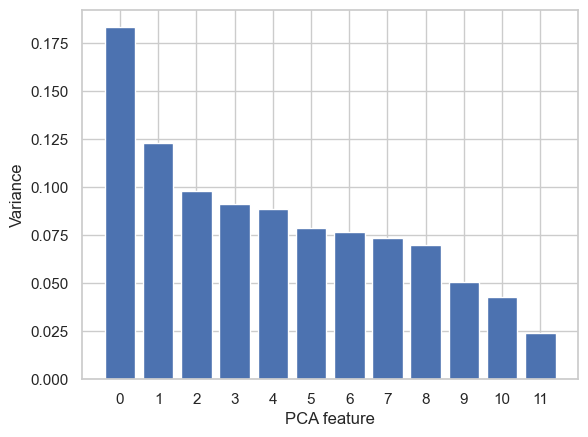

In [192]:
x = df.copy()
scaler = StandardScaler()

x = scaler.fit_transform(x)
model = PCA(n_components=12)
model.fit(x)

features = range(model.n_components_)
plt.bar(features, model.explained_variance_ratio_)
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.xticks(features)
plt.show()

## df with PCA transformation

In [193]:
pca = PCA(n_components=5)  
df_pca = pd.DataFrame(pca.fit_transform(df))

In [194]:
df_pca.head(10)

0         1         2         3         4
0 -1.428762 -0.185455 -1.364131 -1.979258 -0.612692
1 -2.756073 -1.217543 -0.554549 -0.068574  0.434023
2 -0.060246  1.008801  0.061945  0.198574 -0.645861
3 -0.229138 -0.225308 -0.709078 -1.768250 -0.069244
4  5.859477  0.348743 -1.291530  0.653441  0.070684
5  8.042367 -1.858918  0.177751  1.279134 -0.511339
6 -3.134766  2.177157 -0.929638  1.865813 -0.066039
7 -2.165441 -0.962211 -0.215301 -0.249307 -0.729748
8 -3.262184 -0.992591 -0.493318 -0.633875  0.397506
9  1.676361  2.938207  2.895028 -1.229226  0.081569

## normalized df

In [195]:
df_normalized = df.copy()
scaler = Normalizer()
kmeans = KMeans(n_clusters = 5,random_state=14)
df_normalized = pd.DataFrame(scaler.fit_transform(df_normalized))

plan :
- define functions to do pca and tsne visualizations
- pick metric to evaluate models with 
- test and pick best params for models:
**Kmeans, hierarchical clustering, dbscan, gmm**
- pick best one

# Visualization functions

In [196]:
def pca_visualization(df,clusters):
    pca = PCA(n_components=2)  
    X_pca = pca.fit_transform(df)
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],hue=clusters, palette='tab20', legend='full')
    plt.title('K-means Clustering (PCA Visualization)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

In [197]:
def pca_3d(df,clusters):
    pca = PCA(n_components=3)  

    X_pca = pca.fit_transform(df)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=clusters, cmap='tab20')

    ax.set_title('K-means Clustering (3D PCA Visualization)')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    legend1 = ax.legend(*scatter.legend_elements(), title='Clusters')
    ax.add_artist(legend1)

    plt.show()

In [198]:
def tsne_visualization(dataframe, predicted_clusters):
    tsne = TSNE(n_components=2, random_state=69)
    tsne_results = tsne.fit_transform(dataframe)
    tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
    tsne_df['Cluster'] = predicted_clusters
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x='TSNE1', y='TSNE2',
        hue='Cluster',
        palette=sns.color_palette('hsv', len(set(predicted_clusters))),
        data=tsne_df,
        legend='full',
        alpha=0.7
    )
    plt.title('t-SNE Visualization of Clusters')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Cluster')
    plt.show()

In [199]:
def plot_kmeans(df, n_clusters, i=0, j=1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(df)
    centroids = kmeans.cluster_centers_

    plt.figure(figsize=(10, 6))
    plt.scatter(df.iloc[:, i], df.iloc[:, j], c=labels, cmap='viridis', marker='o', s=50)
    plt.scatter(centroids[:, i], centroids[:, j], c='red', marker='x', s=200)

    plt.title(f'KMeans Clustering with {n_clusters} Clusters')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.grid(True)
    plt.show()

In [200]:
def plot_kmeans_3d(df, n_clusters, i=0, j=1, k=2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(df)
    centroids = kmeans.cluster_centers_

    sns.set(style="whitegrid")
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(df.iloc[:, i], df.iloc[:, j], df.iloc[:, k], c=labels, cmap='viridis', marker='o', edgecolor='w', s=100, alpha=0.6)
    ax.scatter(centroids[:, i], centroids[:, j], centroids[:, k], c='red', marker='X', s=300, edgecolor='k', linewidths=2, zorder=10)
    
    ax.set_title(f'KMeans Clustering with {n_clusters} Clusters', fontsize=16)
    ax.set_xlabel('Feature 1', fontsize=14)
    ax.set_ylabel('Feature 2', fontsize=14)
    ax.set_zlabel('Feature 3', fontsize=14)
    
    cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
    cbar.set_label('Cluster Label', fontsize=14)
    
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.show()

# Cluster interpretation

In [201]:
# Function which returns table of clusters and columns. value 1 in column indicates that in this cluster value of this column is the highest in comparison to other clusters
# on average etc
# this function helps to interprete characteristics of clusters

def interprete_clusters(df,clusters):
    df2 =  df.copy()
    df2['cluster'] = clusters 
    c =df2.groupby('cluster').agg('mean')
    c= c.rank(ascending=False, method='average')
    return c

# Metrics

During hyperparameter optimalization we will evaluate model by these metrics:
- Silhouette score
- Davies-Bouldin score
- Caliński-Harabasz score
- Model inertia

we will also take in account our subjective opinion about how well songs are clustered

In [202]:
def metrics(df,model):
    clusters = model.fit_predict(df)
    if len(set(clusters)) < 2:
        return [float('-inf'),float('inf'),float('-inf')]
    silhouette = silhouette_score(df,clusters)
    bouldin = davies_bouldin_score(df,clusters) 
    harabasz = calinski_harabasz_score(df,clusters)
    print(f'Silhouette: {silhouette}')
    print(f'Bouldin: {bouldin}')
    print(f'Harabasz: {harabasz}')
    return [silhouette, bouldin, harabasz]

# Hyperparameter tuning

## Kmeans

In kmeans there is one main hyperparameter 
- n_clusters


In [203]:
# best random seed for kmeans
maxi =0
maxsil =-10
for i in range(2,100):
    model = KMeans(n_clusters = 5,random_state=i)
    x = metrics(df,model)
    if x[0]>maxsil:
        maxsil=x[0]
        maxi=i
print(maxi)

Silhouette: 0.2600030203245853
Bouldin: 1.1665059375443128
Harabasz: 284.75081459814953
Silhouette: 0.2596873874653591
Bouldin: 1.1670315206201285
Harabasz: 285.06796901703626
Silhouette: 0.2589279945572172
Bouldin: 1.1756411879377964
Harabasz: 285.00757885457267
Silhouette: 0.2589279945572172
Bouldin: 1.1756411879377962
Harabasz: 285.0075788545727
Silhouette: 0.2589279945572172
Bouldin: 1.1756411879377962
Harabasz: 285.0075788545727
Silhouette: 0.26052797158929614
Bouldin: 1.1624669871610895
Harabasz: 284.6510565435874
Silhouette: 0.2589279945572172
Bouldin: 1.1756411879377964
Harabasz: 285.0075788545726
Silhouette: 0.25882213278575067
Bouldin: 1.17558327911371
Harabasz: 284.9699130417826
Silhouette: 0.2599148379635497
Bouldin: 1.1649378012860805
Harabasz: 284.7315931936453
Silhouette: 0.2596480418121374
Bouldin: 1.1683685448239989
Harabasz: 284.95435878994346
Silhouette: 0.2608107701680677
Bouldin: 1.171541534641181
Harabasz: 284.9179768761038
Silhouette: 0.2596480418121374
Bouldin: 

In [204]:
def count_clustering_scores(X, cluster_num, model, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k, random_state=42)
        labels = model_instance.fit_predict(X)
        score = score_fun(X, labels)
        scores.append(score)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

# Function to create subplots
def plot_clustering_scores(df):
    cluster_num_seq = range(2, 21)
    
    # Elbow method
    wcss = []
    for k in cluster_num_seq:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
    
    # Silhouette method
    silhouette_vec = count_clustering_scores(df, cluster_num_seq, KMeans, silhouette_score)
    
    # Calinski-Harabasz method
    calinski_harabasz_vec = count_clustering_scores(df, cluster_num_seq, KMeans, calinski_harabasz_score)
    
    # Davies-Bouldin method
    davies_bouldin_vec = count_clustering_scores(df, cluster_num_seq, KMeans, davies_bouldin_score)
    
    # Creating plots
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    # Elbow method
    axs[0, 0].plot(cluster_num_seq, wcss, 'bx-')
    axs[0, 0].set_xlabel('k')
    axs[0, 0].set_ylabel('WCSS')
    axs[0, 0].set_title('Elbow Method')
    axs[0, 0].grid(True)
    
    # Silhouette method
    axs[0, 1].plot(cluster_num_seq, silhouette_vec, 'bx-')
    axs[0, 1].set_xlabel('k')
    axs[0, 1].set_ylabel('Silhouette score')
    axs[0, 1].set_title('Silhouette Method')
    axs[0, 1].grid(True)
    
    # Calinski-Harabasz method
    axs[1, 0].plot(cluster_num_seq, calinski_harabasz_vec, 'bx-')
    axs[1, 0].set_xlabel('k')
    axs[1, 0].set_ylabel('Calinski-Harabasz score')
    axs[1, 0].set_title('Calinski-Harabasz Method')
    axs[1, 0].grid(True)
    
    # Davies-Bouldin method
    axs[1, 1].plot(cluster_num_seq, davies_bouldin_vec, 'bx-')
    axs[1, 1].set_xlabel('k')
    axs[1, 1].set_ylabel('Davies-Bouldin score')
    axs[1, 1].set_title('Davies-Bouldin Method')
    axs[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()


### basic preprocessed df

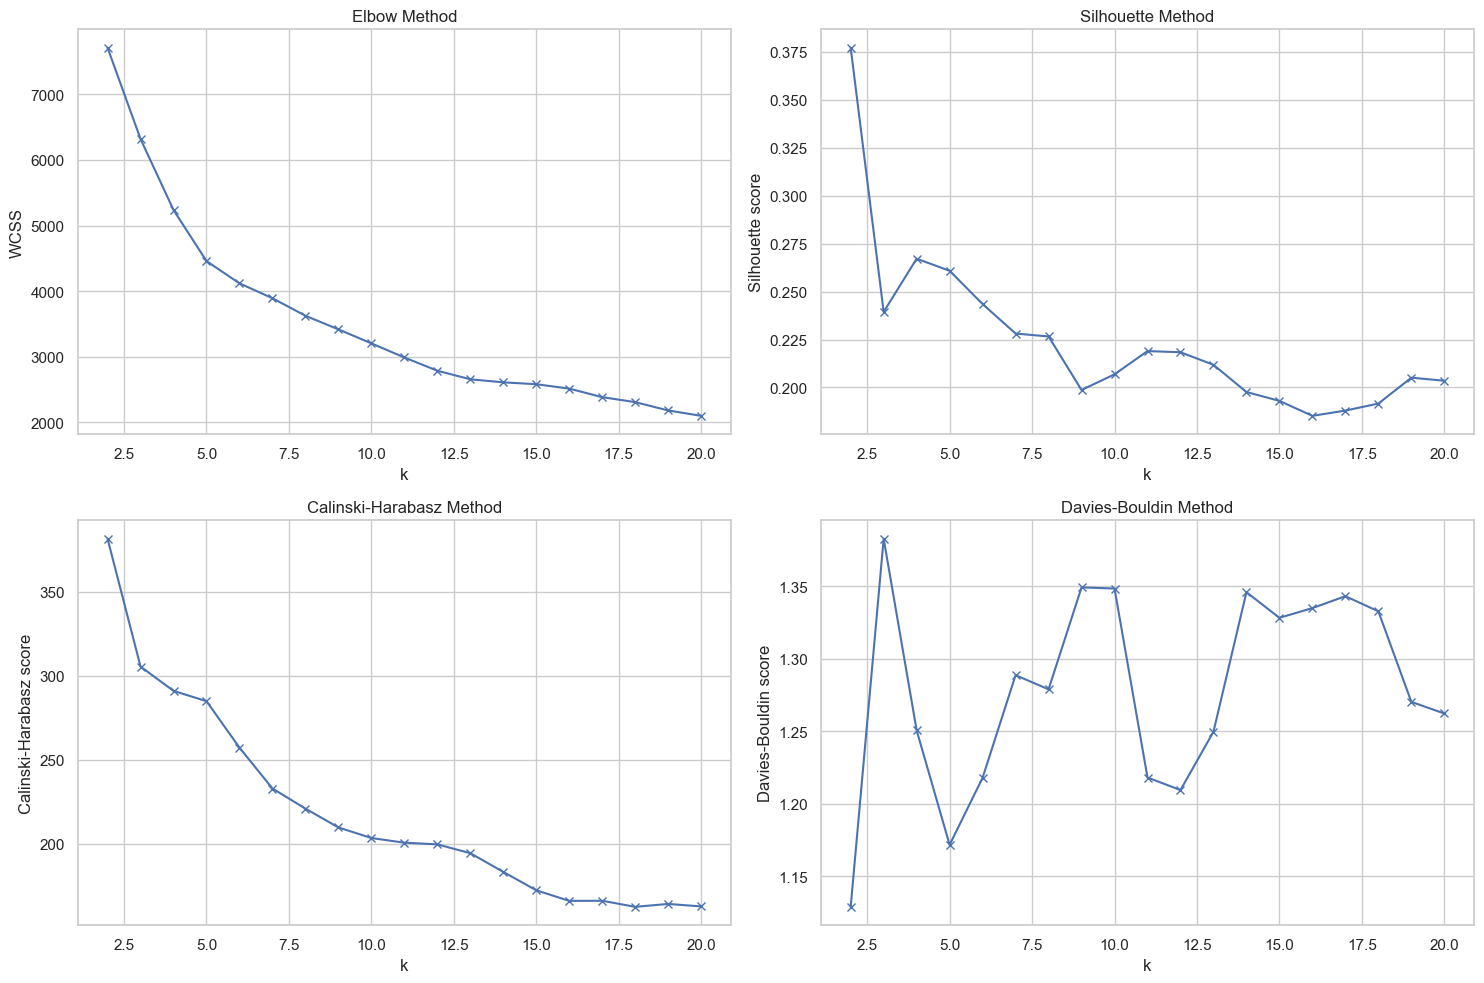

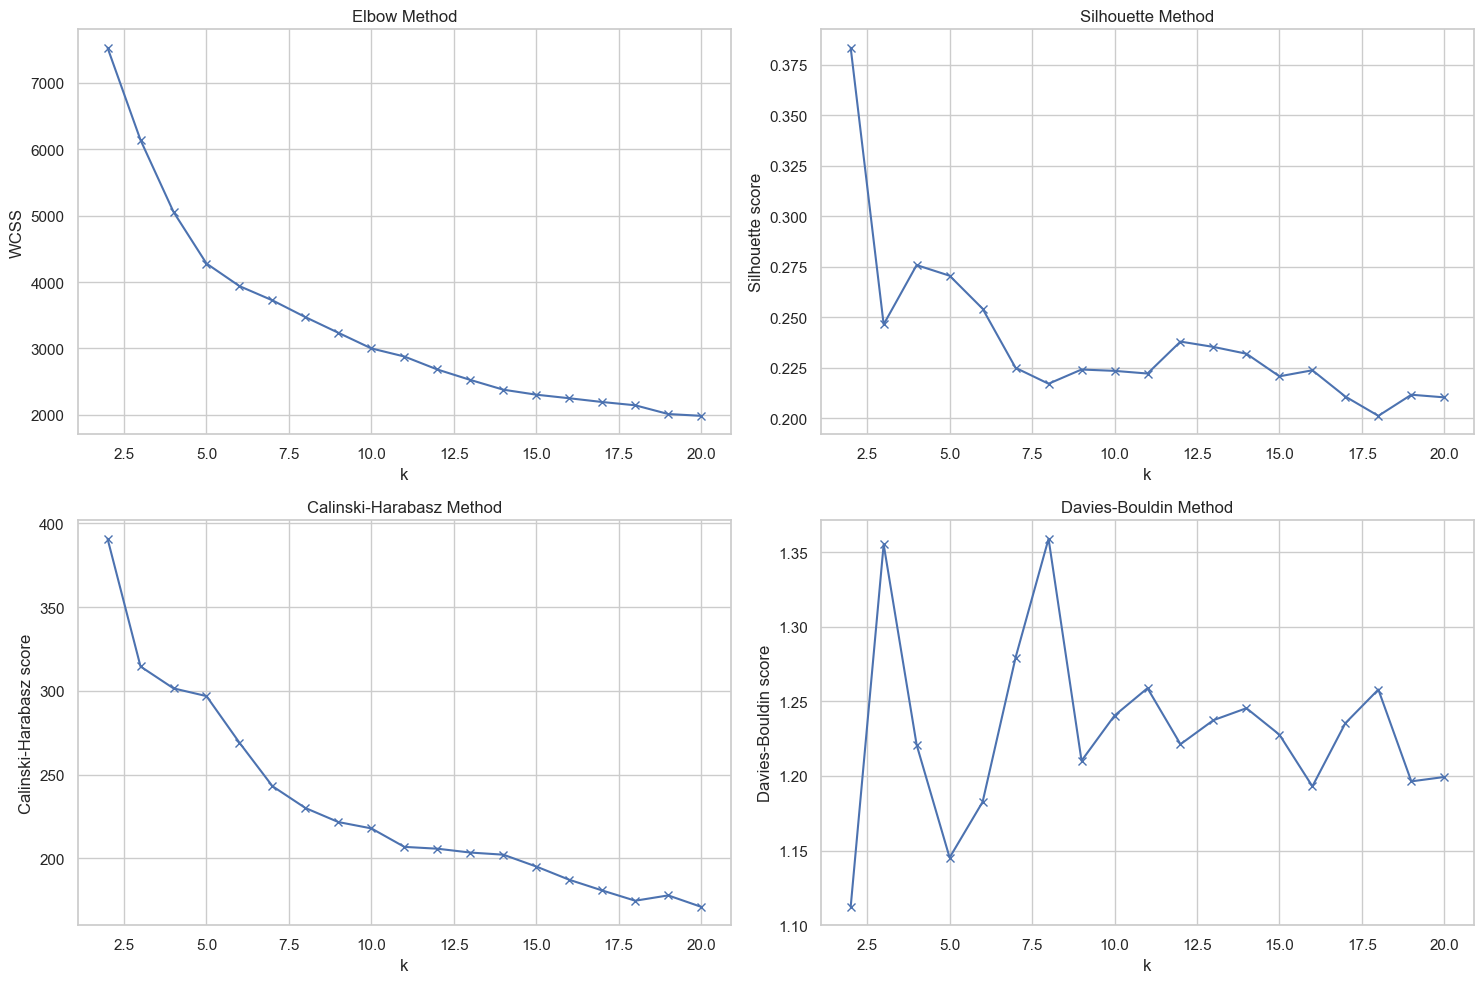

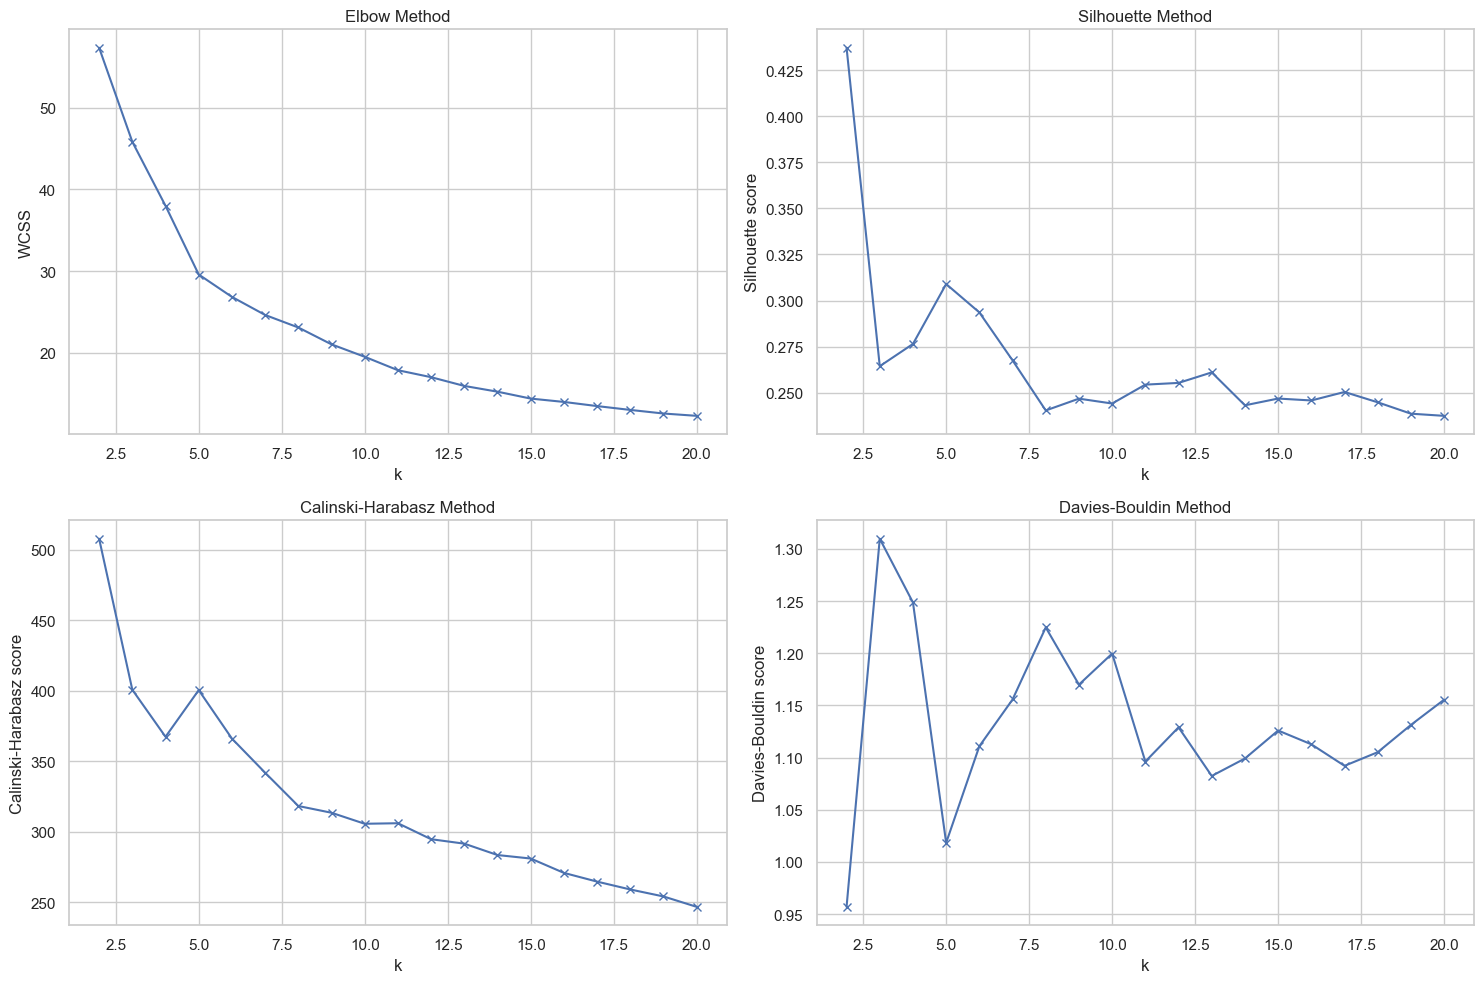

In [205]:
plot_clustering_scores(df)
plot_clustering_scores(df_pca)
plot_clustering_scores(df_normalized)

5 is the best number of clusters

In [206]:
metrics(df,kmeans)
print(f"Inertia: {kmeans.inertia_}")

Silhouette: 0.2618830723811171
Bouldin: 1.1678687224533326
Harabasz: 284.843018132022
Inertia: 4459.132565175808


In [207]:
metrics(df_normalized,kmeans)
print(f"Inertia: {kmeans.inertia_}")

Silhouette: 0.3105456110047956
Bouldin: 1.0113674249361524
Harabasz: 400.75386950908404
Inertia: 29.565373785326244


In [208]:
metrics(df_pca,kmeans)
print(f"Inertia: {kmeans.inertia_}")

Silhouette: 0.27211607584501474
Bouldin: 1.1369315266790376
Harabasz: 296.84507336630907
Inertia: 4278.56143452863


### kmeans visualisation

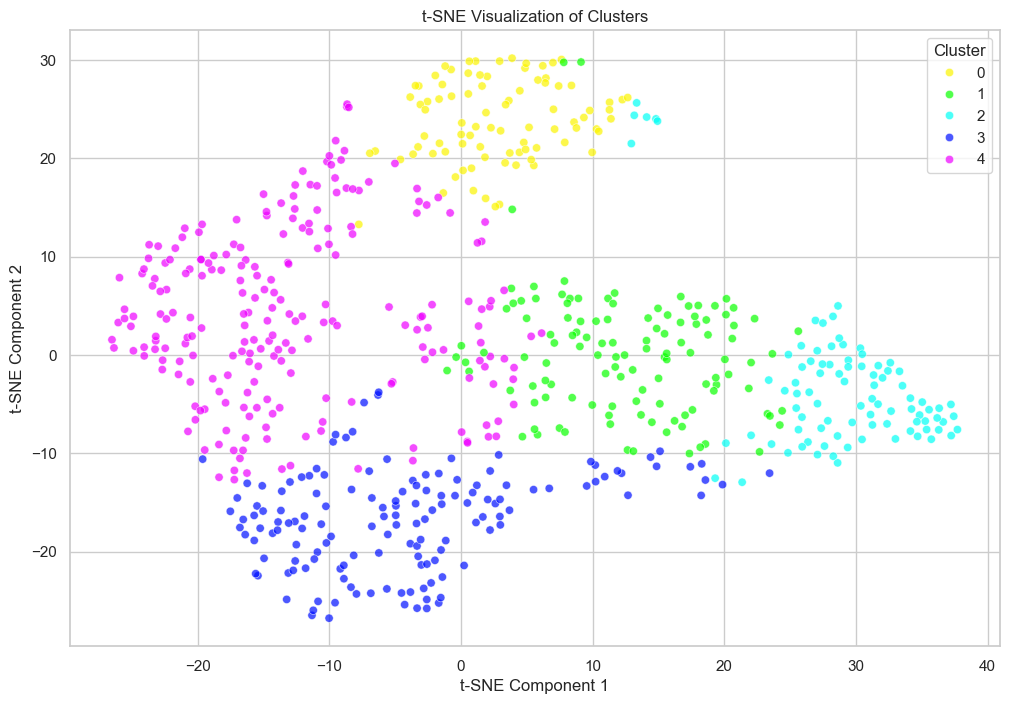

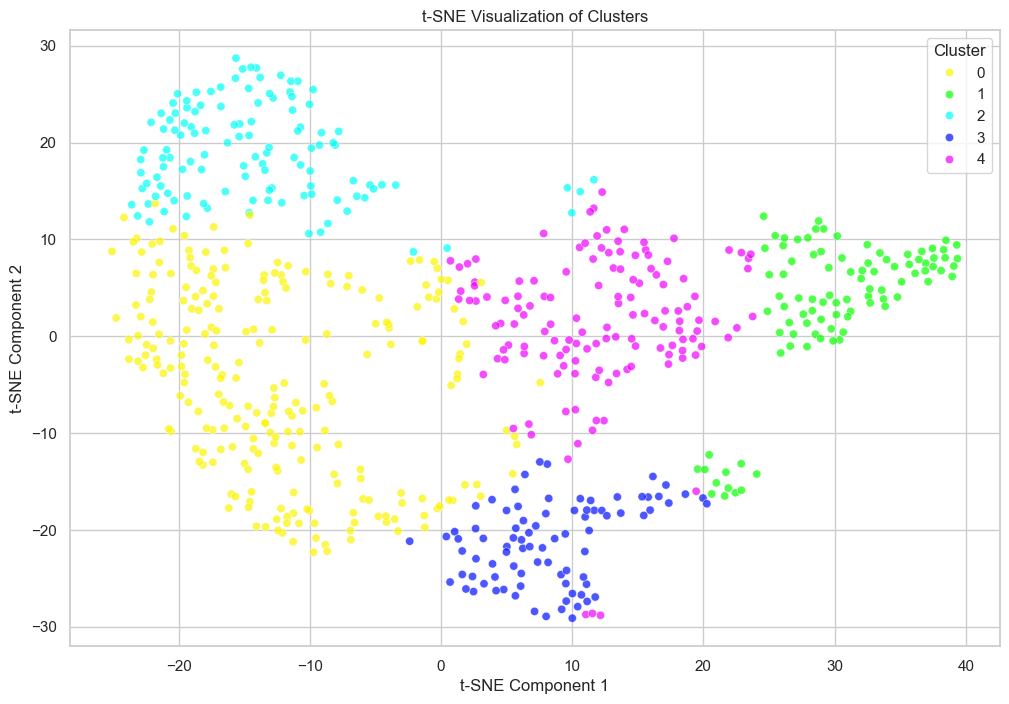

In [209]:
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=14)
clusters = kmeans.fit_predict(df)
tsne_visualization(df,clusters)

clusters = kmeans.fit_predict(df_normalized)
tsne_visualization(df_normalized,clusters)

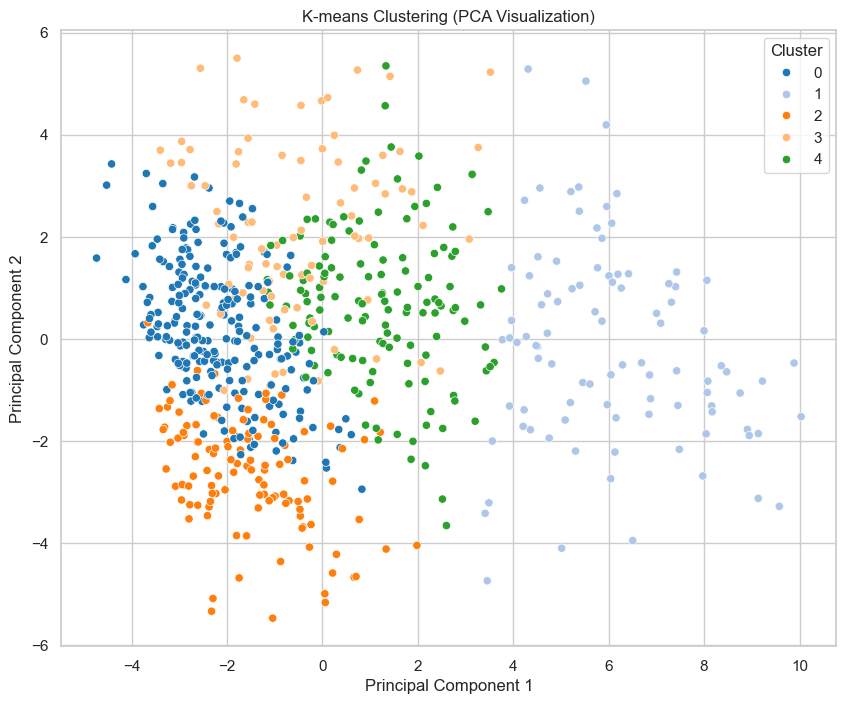

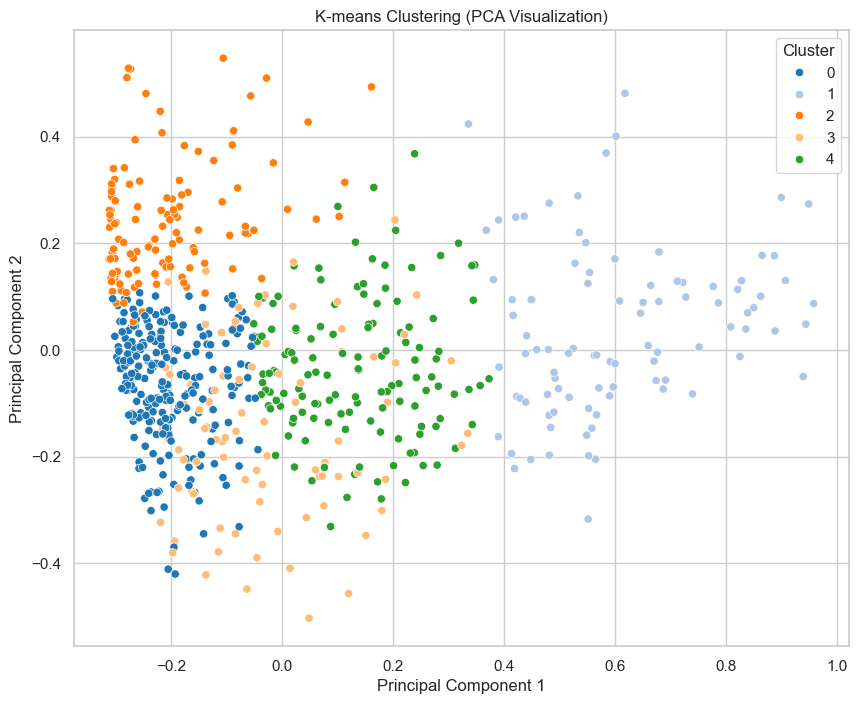

In [210]:
pca_visualization(df,clusters)
pca_visualization(df_normalized,clusters)

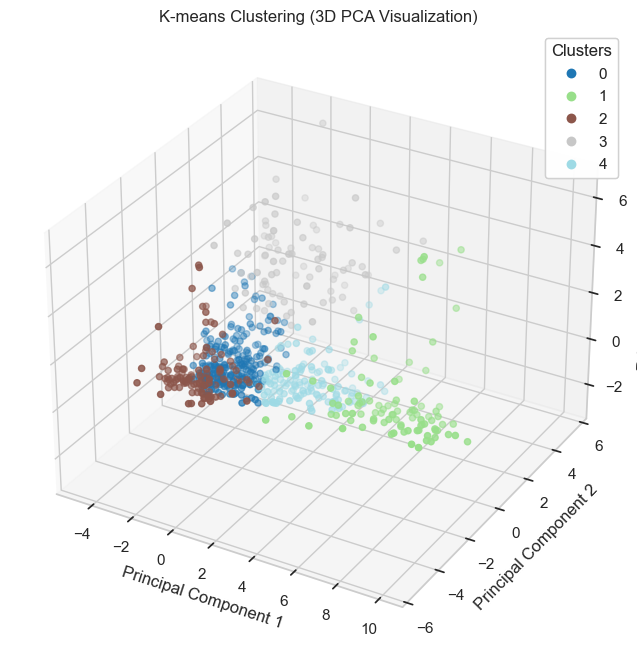

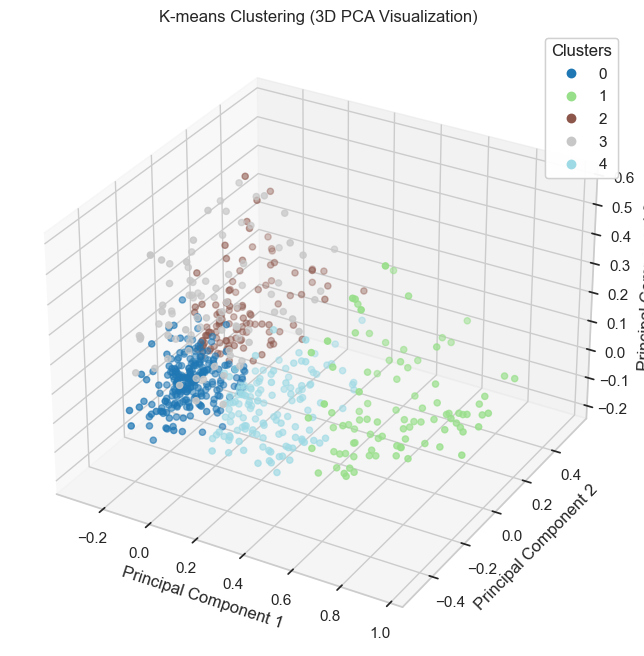

In [211]:
pca_3d(df,clusters)
pca_3d(df_normalized,clusters)

## DBSCAN

For this algorithm we will optimize two params:
- epsilon
- minPts

ps. dbscan probably will not be the best algorithm

psps it is very bad

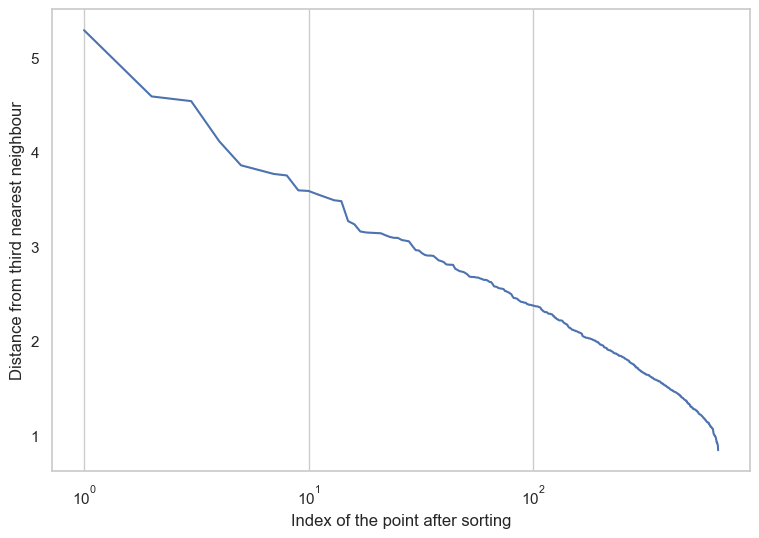

In [212]:
minPts = 10
nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=minPts).fit(df)
distances, indices = nbrs.kneighbors(df)
distanceDec = sorted(distances[:,minPts-1], reverse=True)
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)

plt.xlabel('Index of the point after sorting')
plt.ylabel('Distance from third nearest neighbour')
ax1.plot(list(range(1,df.shape[0]+1)), distanceDec)

plt.xscale('log')
plt.grid(axis='y')

plt.show()

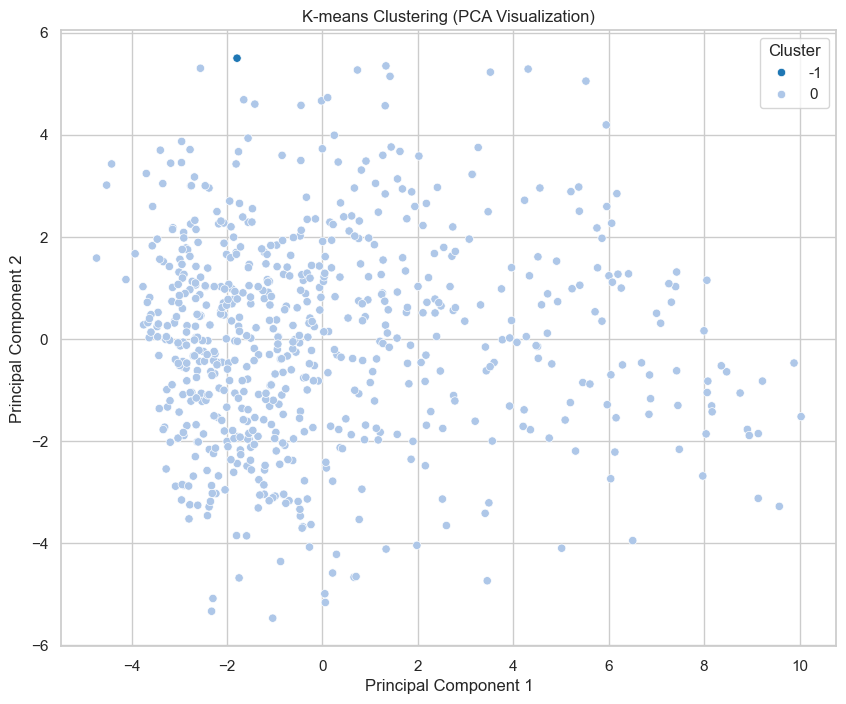

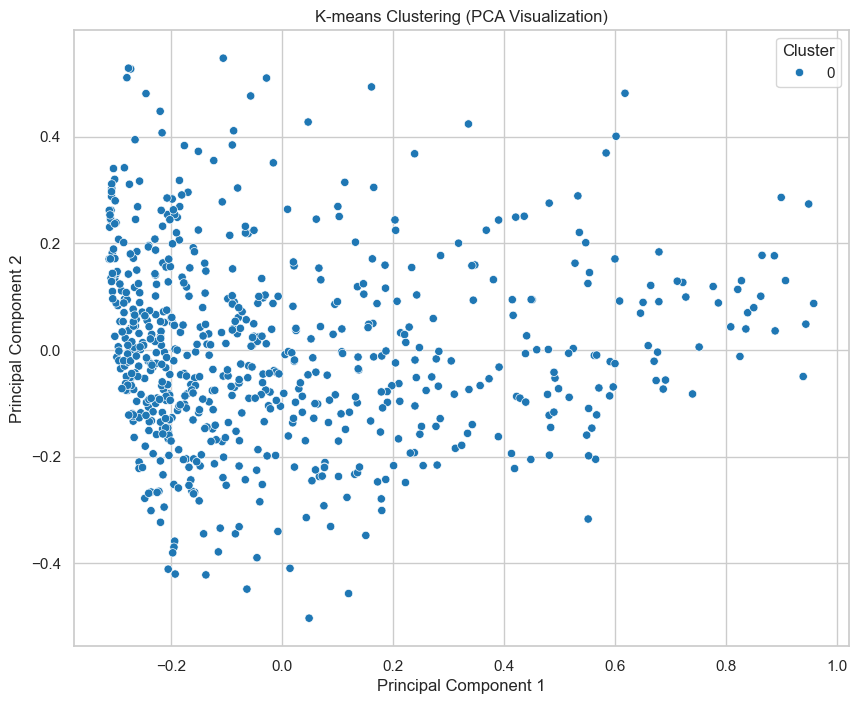

In [213]:
model = DBSCAN(eps = 3.5, min_samples = 10)
pca_visualization(df,model.fit_predict(df))
pca_visualization(df_normalized,model.fit_predict(df_normalized))

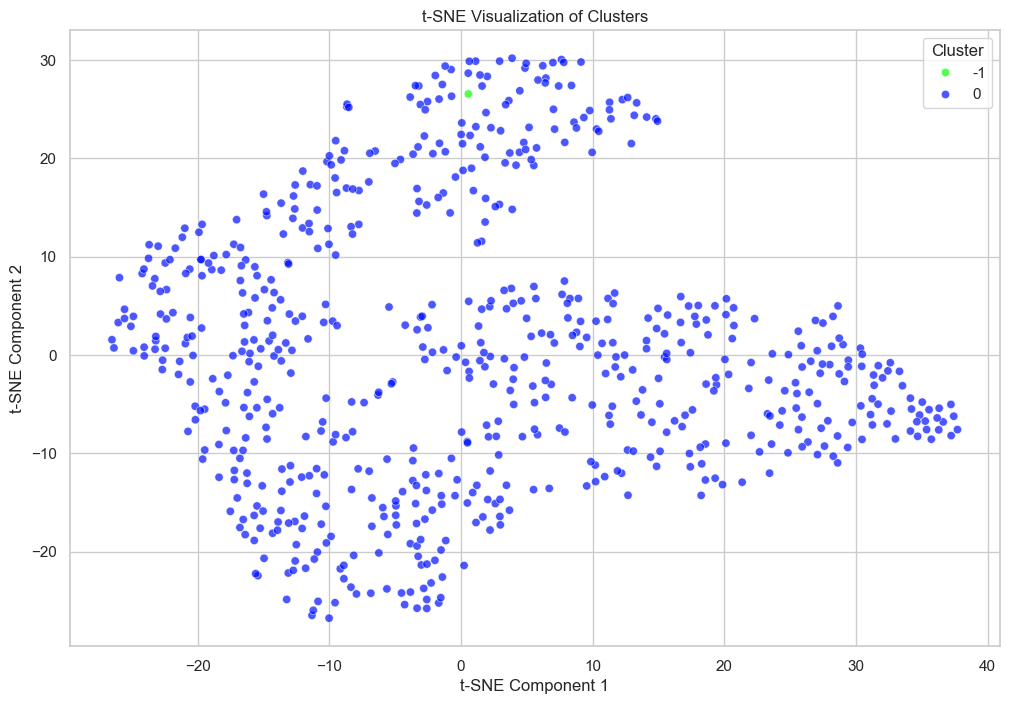

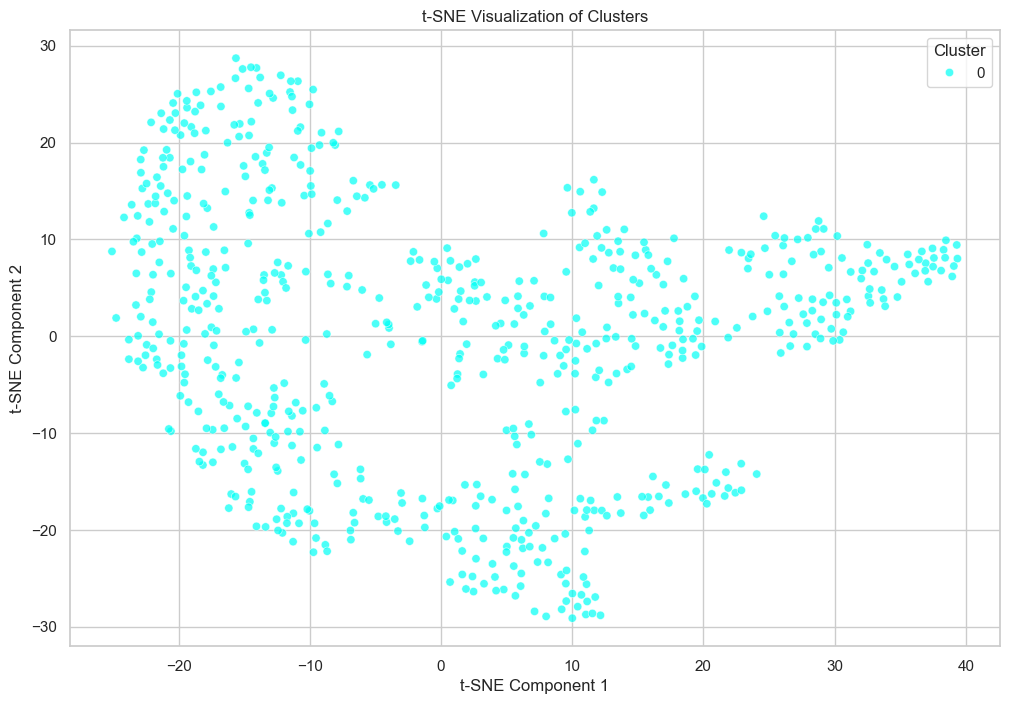

In [214]:
tsne_visualization(df,model.fit_predict(df))
tsne_visualization(df_normalized,model.fit_predict(df_normalized))

In [ ]:
metrics(df,model)

Silhouette: 0.4608887855129431
Bouldin: 0.3997844314413356
Harabasz: 5.312941087049431


[0.4608887855129431, 0.3997844314413356, 5.312941087049431]

DBSCAN doesn't work well when our data is scattered all over the place, without any obvious clusters. It won't be working well for our dataset

## GMM

In [178]:
from sklearn.model_selection import ParameterGrid
def find_best_gmm_params(data, param_grid):
    
    best_score = -1
    best_params = None
    
    # Convert data to numpy array if it is a DataFrame
    if isinstance(data, pd.DataFrame):
        data = data.to_numpy()
    
    # Create a parameter grid
    grid = ParameterGrid(param_grid)
    
    for params in grid:
        # Fit GMM with current parameters
        gmm = mixture.GaussianMixture(**params,random_state=41)
        gmm.fit(data)
        labels = gmm.predict(data)
        
        # Calculate silhouette score
        score = silhouette_score(data, labels)
        
        # Update best score and parameters if current score is better
        if score > best_score:
            best_score = score
            best_params = params
            
    return best_score, best_params

In [216]:
param_grid = {
    'n_components': [4,5,6,7,8,9,10],
    'covariance_type': ['full', 'tied', 'diag', 'spherical']
}

### basic preprocessed df

In [230]:
best_score, best_params = find_best_gmm_params(df, param_grid)
print(f"Best Silhouette Score: {best_score}")
print(f"Best Parameters: {best_params}")

Best Silhouette Score: 0.26193352690232347
Best Parameters: {'covariance_type': 'tied', 'n_components': 4}


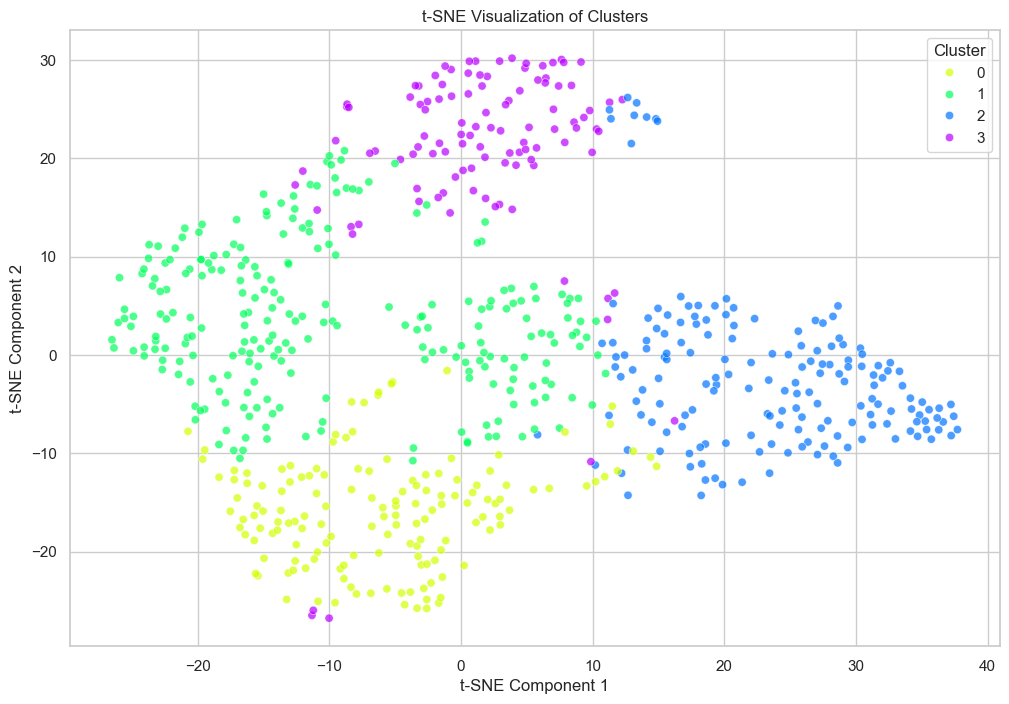

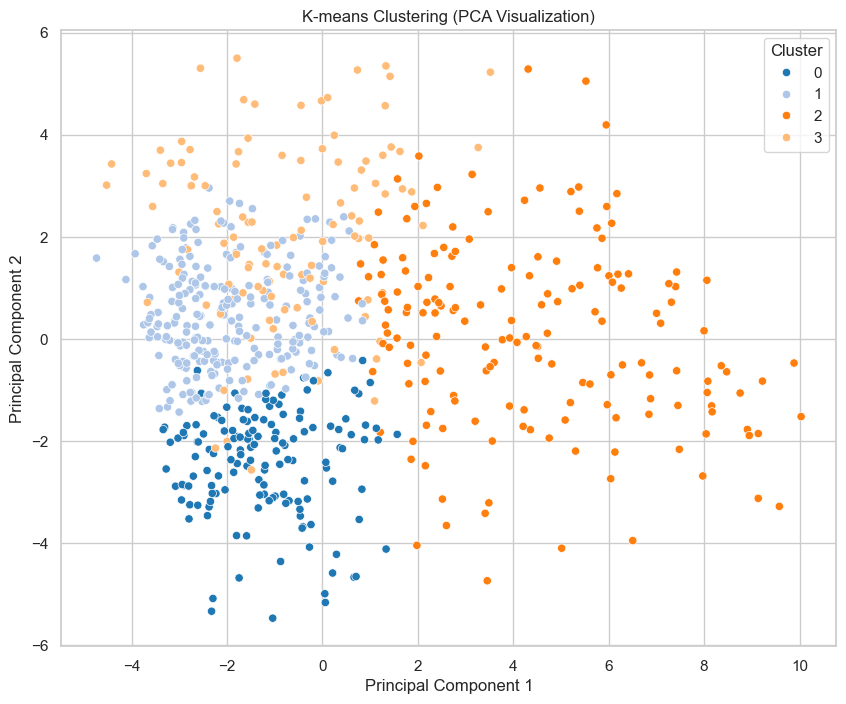

Silhouette: 0.24584828499267478
Bouldin: 1.2756997051825312
Harabasz: 272.85078916764553


[0.24584828499267478, 1.2756997051825312, 272.85078916764553]

In [231]:
gmm = mixture.GaussianMixture(n_components=4, covariance_type='spherical',random_state=13)
gmm_clusters = gmm.fit_predict(df)

tsne_visualization(df,gmm_clusters)
pca_visualization(df,gmm_clusters)
metrics(df,gmm)

### df with pca transformation

In [232]:
best_score, best_params = find_best_gmm_params(df_pca, param_grid)
print(f"Best Silhouette Score: {best_score}")
print(f"Best Parameters: {best_params}")

Best Silhouette Score: 0.2543117220962749
Best Parameters: {'covariance_type': 'spherical', 'n_components': 5}


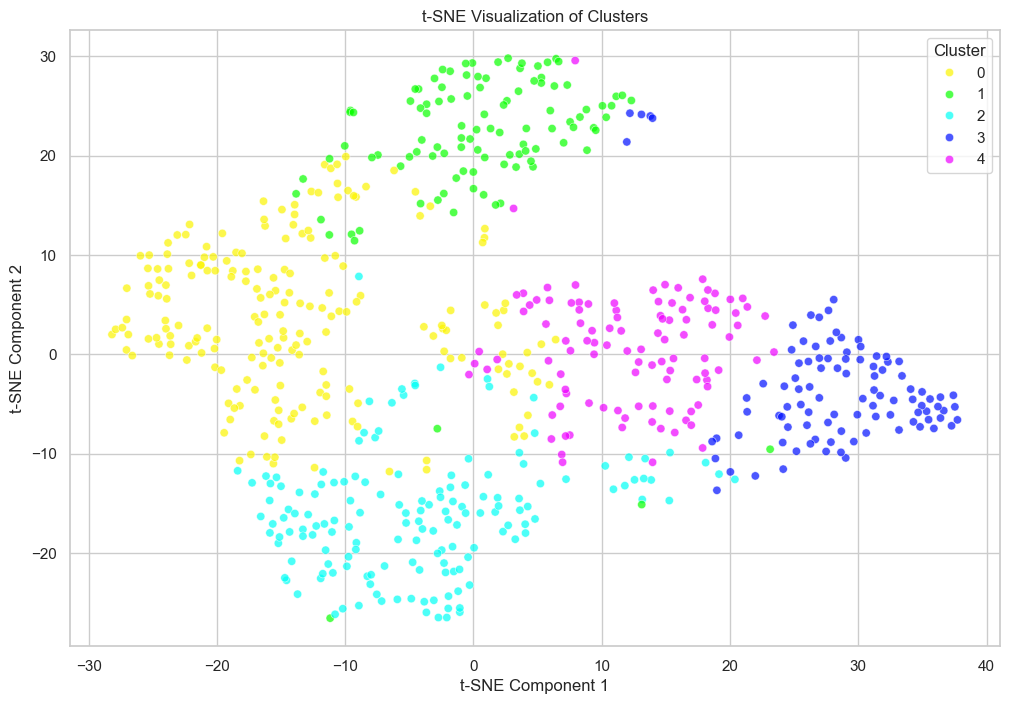

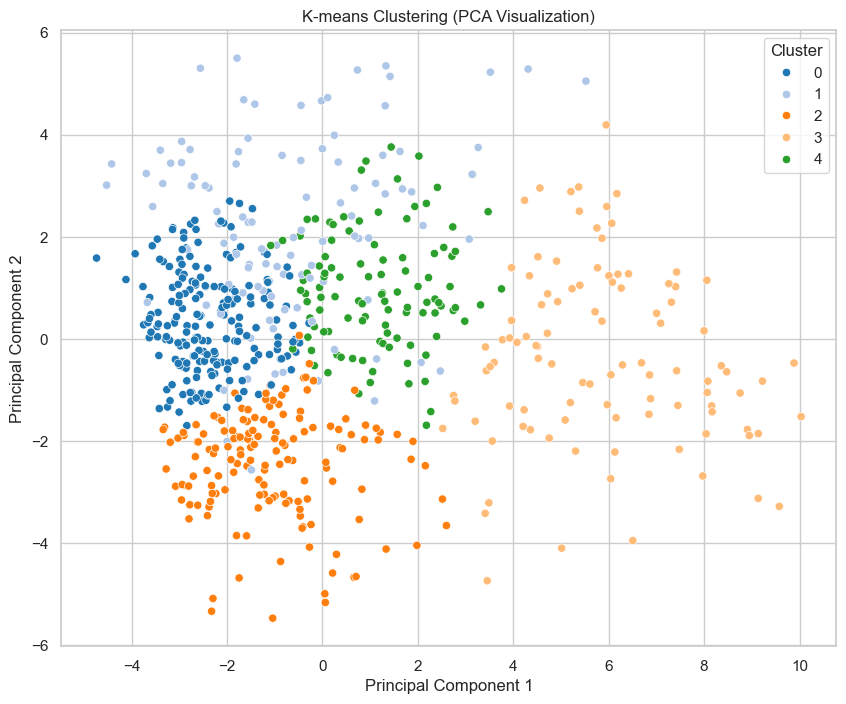

Silhouette: 0.2534611921351645
Bouldin: 1.178467715198083
Harabasz: 285.36622372897824


[0.2534611921351645, 1.178467715198083, 285.36622372897824]

In [233]:
gmm = mixture.GaussianMixture(n_components=5, covariance_type='spherical',random_state=13)
gmm_clusters = gmm.fit_predict(df_pca)

tsne_visualization(df_pca,gmm_clusters)
pca_visualization(df_pca,gmm_clusters)
metrics(df_pca,gmm)

### normalized df

In [234]:
best_score, best_params = find_best_gmm_params(df_normalized, param_grid)
print(f"Best Silhouette Score: {best_score}")
print(f"Best Parameters: {best_params}")

Best Silhouette Score: 0.3035790475163128
Best Parameters: {'covariance_type': 'tied', 'n_components': 6}


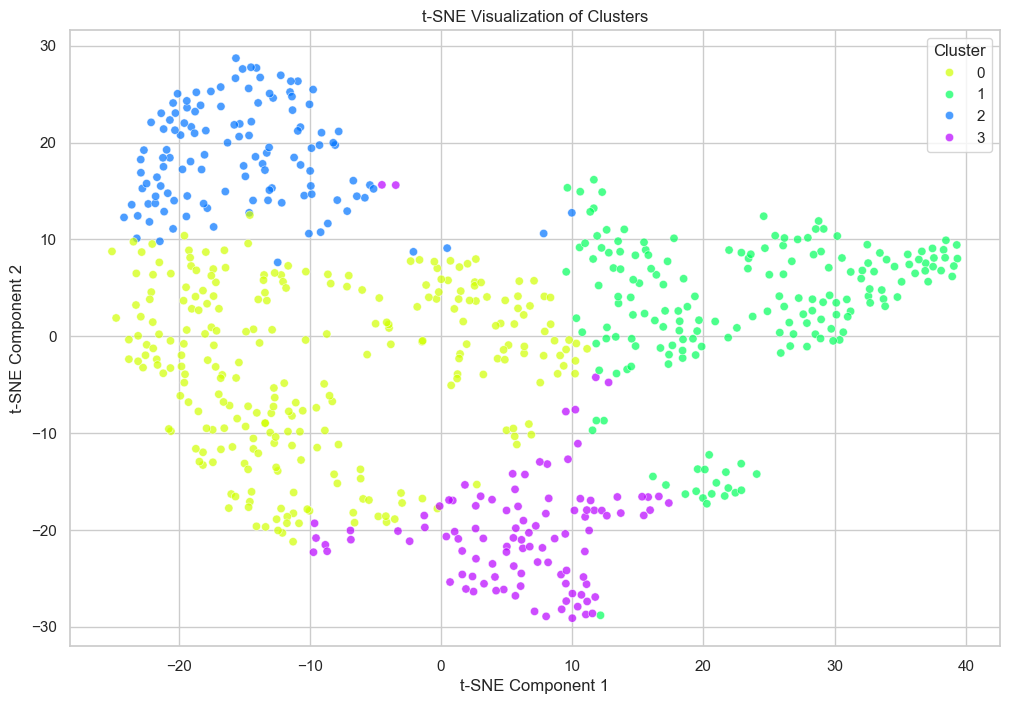

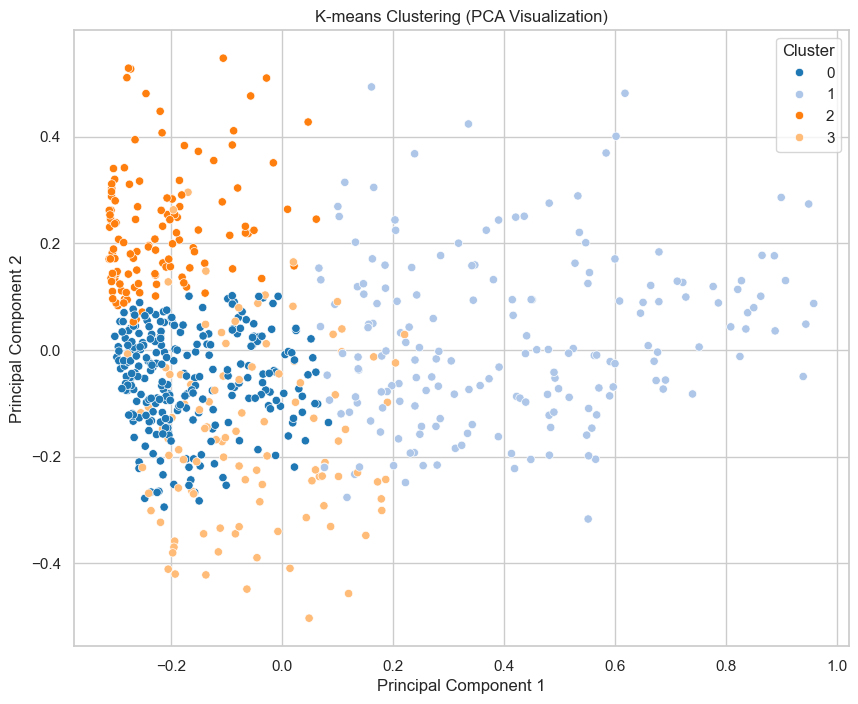

Silhouette: 0.2901794421256403
Bouldin: 1.1020537842499518
Harabasz: 350.19653849471854


[0.2901794421256403, 1.1020537842499518, 350.19653849471854]

In [235]:
gmm = mixture.GaussianMixture(n_components=4, covariance_type='spherical',random_state=13)
gmm_clusters = gmm.fit_predict(df_normalized)

tsne_visualization(df_normalized,gmm_clusters)
pca_visualization(df_normalized,gmm_clusters)
metrics(df_normalized,gmm)

## Hierarchical

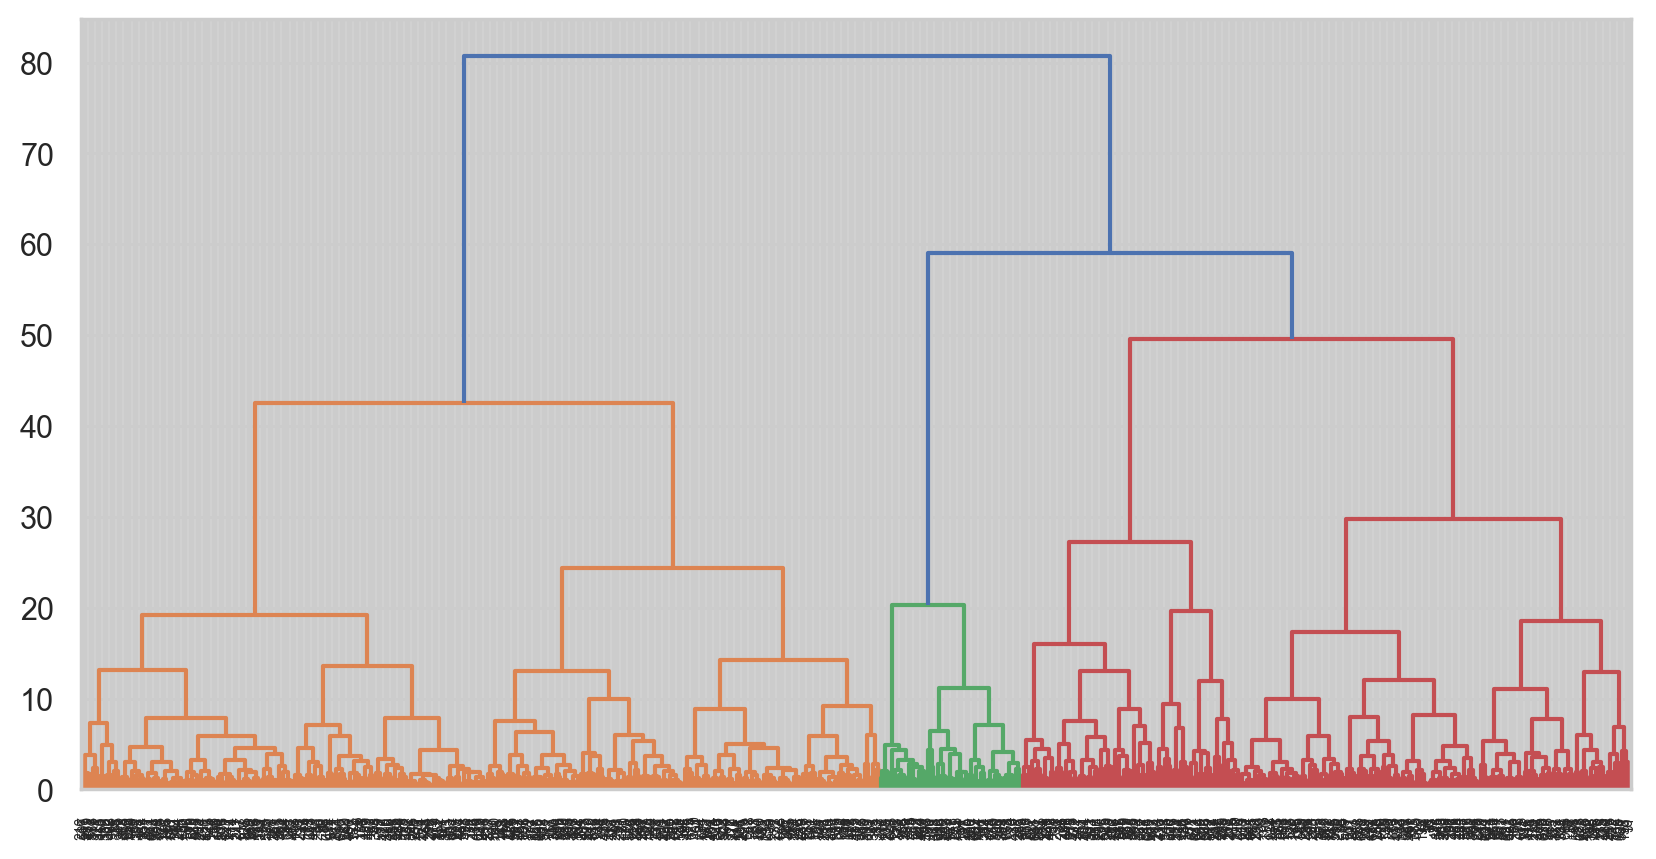

In [236]:
from scipy.cluster import hierarchy


Z = hierarchy.linkage(df, method='ward')
plt.figure(figsize=(10, 5), dpi= 200, facecolor='w', edgecolor='k')
hierarchy.dendrogram(Z)
plt.show()

fixed cluster number

silhouette optimalization

In [237]:
best_score = -1
best_params = None

for n_clusters in range(5, 10):
    for linkage_method in ['ward', 'complete', 'average', 'single']:
        clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method)
        labels = clustering.fit_predict(df)
        score = silhouette_score(df, labels)
        print(f'n_clusters: {n_clusters}, linkage: {linkage_method}, silhouette score: {score}')
        
        if score > best_score:
            best_score = score
            best_params = {'n_clusters': n_clusters, 'linkage': linkage_method}

print('Best parameters:', best_params)

n_clusters: 5, linkage: ward, silhouette score: 0.21201756692946366
n_clusters: 5, linkage: complete, silhouette score: 0.22756849153179892
n_clusters: 5, linkage: average, silhouette score: 0.2934391883298495
n_clusters: 5, linkage: single, silhouette score: 0.21601777038435283
n_clusters: 6, linkage: ward, silhouette score: 0.2056920912617257
n_clusters: 6, linkage: complete, silhouette score: 0.21579989413185244
n_clusters: 6, linkage: average, silhouette score: 0.2708515234564135
n_clusters: 6, linkage: single, silhouette score: 0.1248667116534334
n_clusters: 7, linkage: ward, silhouette score: 0.21440633015611638
n_clusters: 7, linkage: complete, silhouette score: 0.18191360727071665
n_clusters: 7, linkage: average, silhouette score: 0.2664068830863431
n_clusters: 7, linkage: single, silhouette score: 0.127661749041923
n_clusters: 8, linkage: ward, silhouette score: 0.1993284840968685
n_clusters: 8, linkage: complete, silhouette score: 0.1769711142773524
n_clusters: 8, linkage: av

In [238]:
print(metrics(df,AgglomerativeClustering(n_clusters=5,linkage='average')))

Silhouette: 0.2934391883298495
Bouldin: 0.87921324185064
Harabasz: 106.04264617908154
[0.2934391883298495, 0.87921324185064, 106.04264617908154]


harabasz optimalization

In [239]:
best_score = -1
best_params = None

for n_clusters in range(5, 10):
    for linkage_method in ['ward', 'complete', 'average', 'single']:
        clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method)
        labels = clustering.fit_predict(df)
        score = calinski_harabasz_score(df, labels)
        print(f'n_clusters: {n_clusters}, linkage: {linkage_method}, calinski harabasz: {score}')
        
        if score > best_score:
            best_score = score
            best_params = {'n_clusters': n_clusters, 'linkage': linkage_method}

print('Best parameters:', best_params)

n_clusters: 5, linkage: ward, calinski harabasz: 236.3777587077633
n_clusters: 5, linkage: complete, calinski harabasz: 190.81380845504697
n_clusters: 5, linkage: average, calinski harabasz: 106.04264617908154
n_clusters: 5, linkage: single, calinski harabasz: 6.19387271101581
n_clusters: 6, linkage: ward, calinski harabasz: 220.04451079295603
n_clusters: 6, linkage: complete, calinski harabasz: 181.1745550081243
n_clusters: 6, linkage: average, calinski harabasz: 126.60947058203378
n_clusters: 6, linkage: single, calinski harabasz: 5.520088304118275
n_clusters: 7, linkage: ward, calinski harabasz: 209.07180053123432
n_clusters: 7, linkage: complete, calinski harabasz: 171.89301170595684
n_clusters: 7, linkage: average, calinski harabasz: 132.65170330762874
n_clusters: 7, linkage: single, calinski harabasz: 6.348842765624987
n_clusters: 8, linkage: ward, calinski harabasz: 199.69796083893405
n_clusters: 8, linkage: complete, calinski harabasz: 157.72362997311336
n_clusters: 8, linkage:

In [240]:
print(metrics(df,AgglomerativeClustering(n_clusters=5,linkage='ward')))

Silhouette: 0.21201756692946366
Bouldin: 1.2797587574111786
Harabasz: 236.3777587077633
[0.21201756692946366, 1.2797587574111786, 236.3777587077633]


bouldin optimalization

In [241]:
best_score = 1000000
best_params = None

for n_clusters in range(5, 10):
    for linkage_method in ['ward', 'complete', 'average', 'single']:
        clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method)
        labels = clustering.fit_predict(df)
        score = davies_bouldin_score(df, labels)
        print(f'n_clusters: {n_clusters}, linkage: {linkage_method}, davies-bouldin: {score}')
        
        if score < best_score:
            best_score = score
            best_params = {'n_clusters': n_clusters, 'linkage': linkage_method}

print('Best parameters:', best_params)

n_clusters: 5, linkage: ward, davies-bouldin: 1.2797587574111786
n_clusters: 5, linkage: complete, davies-bouldin: 1.4522738659139152
n_clusters: 5, linkage: average, davies-bouldin: 0.87921324185064
n_clusters: 5, linkage: single, davies-bouldin: 0.5687104737493582
n_clusters: 6, linkage: ward, davies-bouldin: 1.3525268788700202
n_clusters: 6, linkage: complete, davies-bouldin: 1.353908187399009
n_clusters: 6, linkage: average, davies-bouldin: 1.070407304785208
n_clusters: 6, linkage: single, davies-bouldin: 0.5659234788651633
n_clusters: 7, linkage: ward, davies-bouldin: 1.411579159716006
n_clusters: 7, linkage: complete, davies-bouldin: 1.333146554022079
n_clusters: 7, linkage: average, davies-bouldin: 1.033693777776362
n_clusters: 7, linkage: single, davies-bouldin: 0.5849628841462398
n_clusters: 8, linkage: ward, davies-bouldin: 1.41924279966253
n_clusters: 8, linkage: complete, davies-bouldin: 1.2689293446084533
n_clusters: 8, linkage: average, davies-bouldin: 1.0484030790881054


In [242]:
print(metrics(df,AgglomerativeClustering(n_clusters=6,linkage='single')))

Silhouette: 0.1248667116534334
Bouldin: 0.5659234788651633
Harabasz: 5.520088304118275
[0.1248667116534334, 0.5659234788651633, 5.520088304118275]


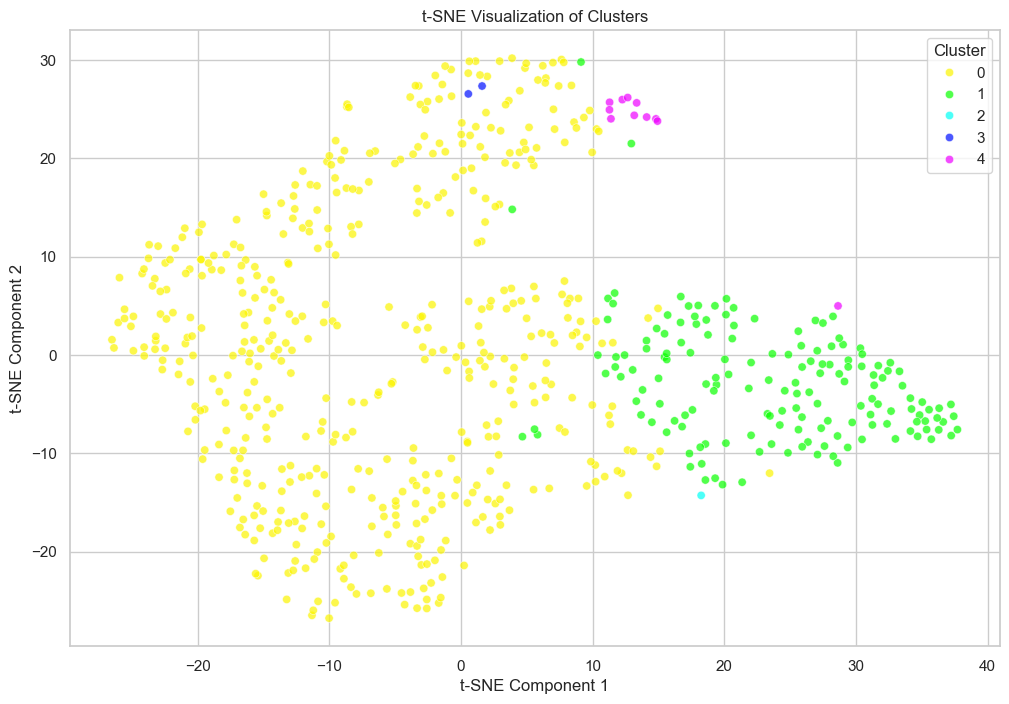

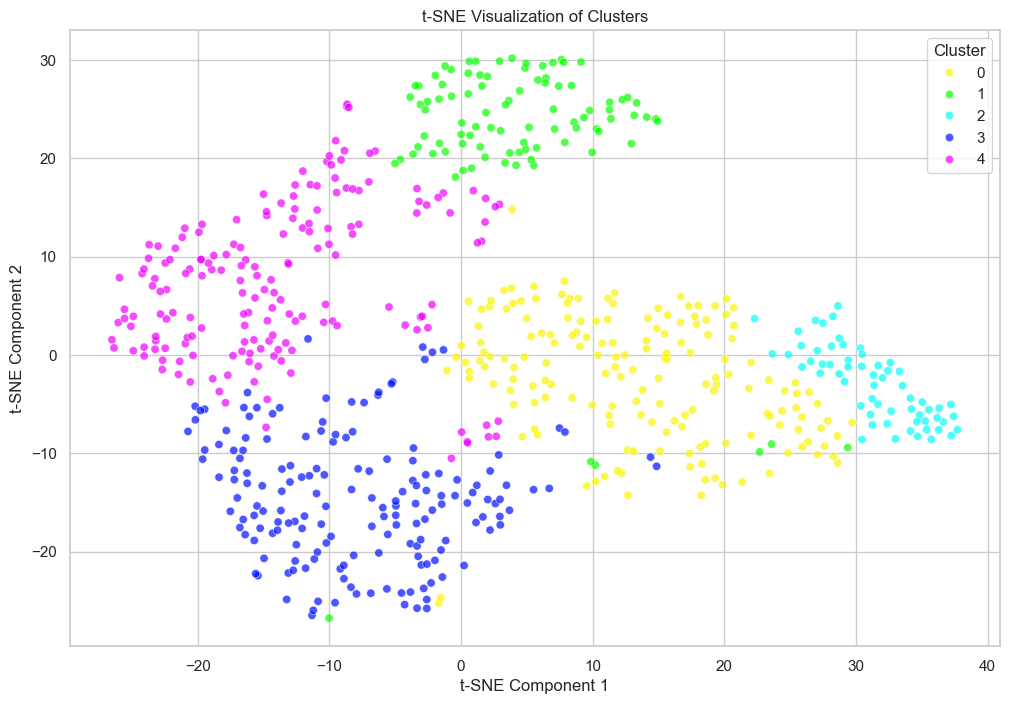

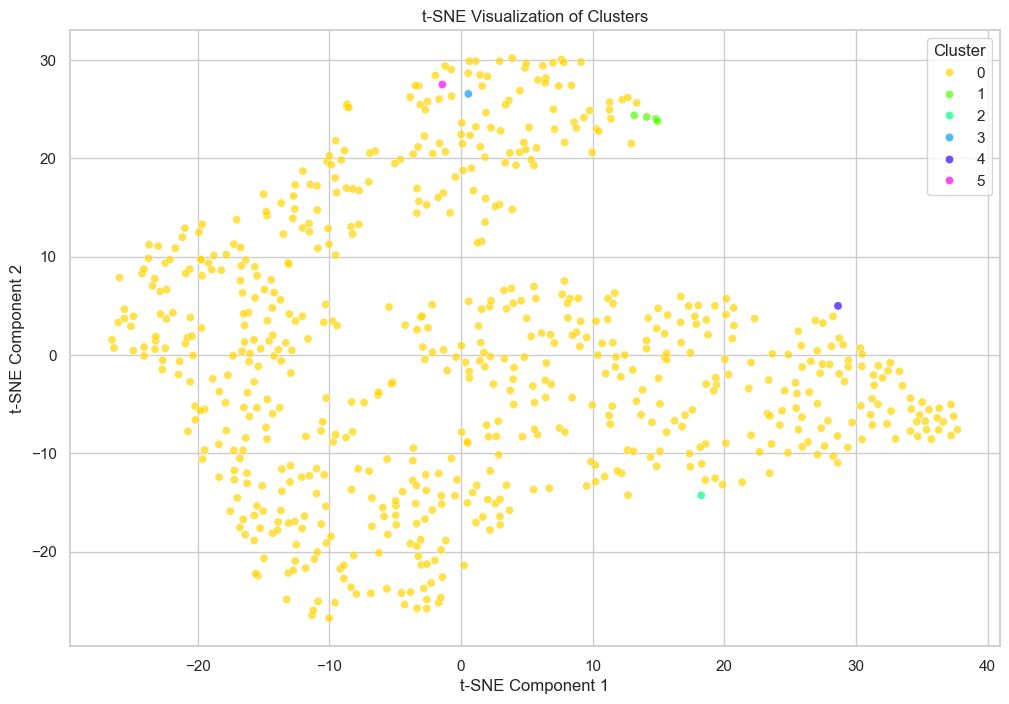

In [243]:
tsne_visualization(df,AgglomerativeClustering(n_clusters=5,linkage='average').fit_predict(df))
tsne_visualization(df,AgglomerativeClustering(n_clusters=5,linkage='ward').fit_predict(df))
tsne_visualization(df,AgglomerativeClustering(n_clusters=6,linkage='single').fit_predict(df))

threshold optimalization

mean of scaled silhouette and harabasz

because only looking at silhouette we will end up with one big cluster and onlu from harabasz with every point as cluster

In [244]:
best_score = -1
best_params = None

for thr in np.arange(0.2, 3, 0.2):
    for linkage_method in ['ward', 'complete', 'average', 'single']:
        clustering = AgglomerativeClustering(n_clusters=None, linkage=linkage_method,distance_threshold = thr)
        labels = clustering.fit_predict(df)
        score1 = calinski_harabasz_score(df, labels)
        score2 = silhouette_score(df,labels)*4000
        score = (score1+score2)/2
        #print(f'n_clusters: {n_clusters}, linkage: {linkage_method}, calinski harabasz: {score}')
        
        if score > best_score:
            best_score = score
            best_params = {'threshold': thr, 'linkage': linkage_method}

print('Best parameters:', best_params)

Best parameters: {'threshold': 2.8000000000000003, 'linkage': 'single'}


In [245]:
metrics( df,AgglomerativeClustering(n_clusters=None, linkage='ward',distance_threshold=2.8))

Silhouette: 0.18304522627903513
Bouldin: 1.0834719268326771
Harabasz: 76.60688502498965


[0.18304522627903513, 1.0834719268326771, 76.60688502498965]

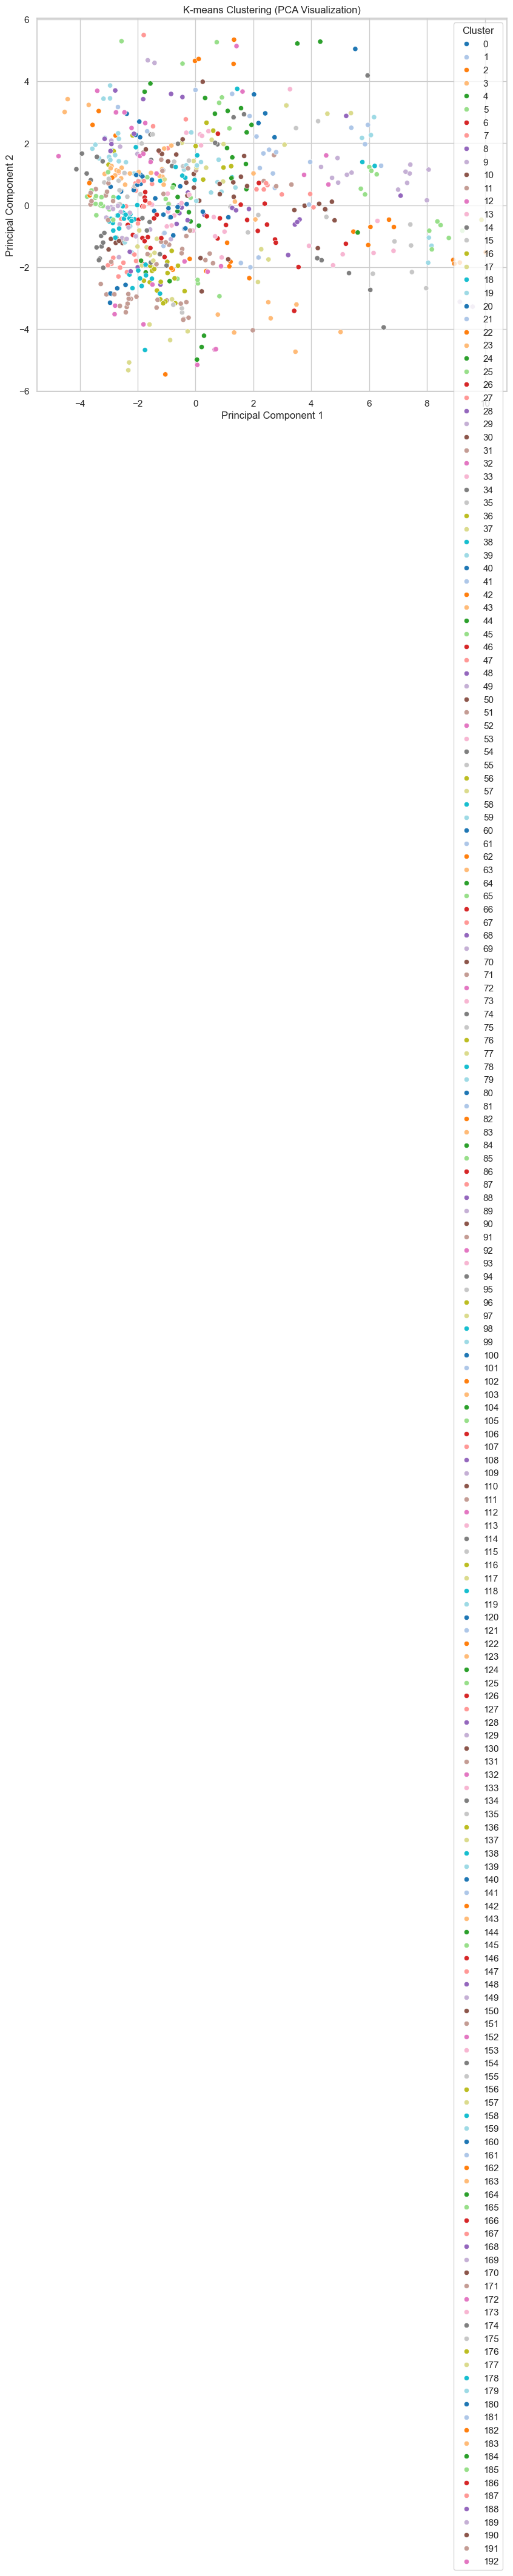

In [246]:
pca_visualization( df,AgglomerativeClustering(n_clusters=None, linkage='ward',distance_threshold=2.2).fit_predict(df))

In [247]:
# it gives us 179 clusters
agg_clusters = AgglomerativeClustering(n_clusters=None, linkage='ward',distance_threshold=2.2).fit_predict(df)
df2 = pd.read_csv('../Data/spotify_modelling.csv')
df2["cluster"] = agg_clusters
df2[df2.cluster ==69].head(7)

# całkiem podobne piosenki

track_name artist(s)_name  artist_count  released_year  \
114                 Shake It Off   Taylor Swift             1           2014   
128  Boy With Luv (feat. Halsey)    Halsey, BTS             2           2019   
501                  Born Singer            BTS             1           2022   

     released_month  released_day  in_spotify_playlists  in_spotify_charts  \
114               1             1                 21335                 13   
128               4            12                  4260                  0   
501               6            10                   279                  0   

        streams  in_apple_playlists  ...  key   mode  danceability_%  \
114  1113838873                 328  ...    G  Major              65   
128  1065580332                 113  ...    B  Minor              65   
501    79095270                   0  ...   G#  Minor              60   

    valence_%  energy_% acousticness_% instrumentalness_%  liveness_%  \
114        95        80              5                  0          41   
128        80        86              9                  0          19   
501        68        84              4                  0          24   

     speechiness_%  cluster  
114             16       69  
128             10       69  
501             11       69  

[3 rows x 25 columns]

# Chosen model

overall best model so far is kmeans with 5 clusters;
it scores :

- Silhouette: 0.3105456110047956
- Bouldin: 1.0113674249361524
- Harabasz: 400.75386950908404
- Inertia: 29.565373785326244

In [248]:
best_model =KMeans(n_clusters = 5,random_state = 14)
clusters = best_model.fit_predict(df_normalized)

In [249]:
df2 = pd.read_csv('../Data/spotify_modelling.csv')
df2 = preprocess_data(df2)
interprete_clusters(df2,clusters)

bpm  key  mode  danceability_%  valence_%  energy_%  acousticness_%  \
cluster                                                                        
0        5.0  3.0   3.0             1.0        2.0       2.0             5.0   
1        3.0  1.0   5.0             5.0        5.0       5.0             1.0   
2        1.0  4.0   4.0             4.0        4.0       1.0             4.0   
3        2.0  2.0   1.0             2.0        3.0       3.0             3.0   
4        4.0  5.0   2.0             3.0        1.0       4.0             2.0   

         instrumentalness_%  liveness_%  speechiness_%  year_group_encoded  \
cluster                                                                      
0                       4.0         3.0            3.0                 3.0   
1                       1.0         4.0            2.0                 5.0   
2                       2.0         1.0            4.0                 4.0   
3                       5.0         2.0            1.0                 1.0   
4                       3.0         5.0            5.0                 2.0   

         artist_popularity  
cluster                     
0                      3.0  
1                      1.0  
2                      2.0  
3                      5.0  
4                      4.0

we can see that :

- **cluster 0:** songs with low BPM but high danceability, perfect for a party playlist

- **cluster 1:** songs from very popular artists like Billie Eilish, featuring high acousticness and instrumentalness, ideal for cafes or restaurants

- **cluster 2:** energetic songs with the highest BPM and liveness by fairly popular artists, great for a running playlist

- **cluster 3:** a playlist for rap lovers, with the highest speechiness, high BPM, and low instrumentalness

- **cluster 4:** positive songs with moderate BPM by lesser-known artists, perfect for setting a great mood and discovering new artists

In [250]:
df2 = pd.read_csv('../Data/spotify_modelling.csv')
df2["cluster"] = clusters
df2[df2.cluster ==0][["track_name", "artist(s)_name", "cluster"]].head(7)

track_name             artist(s)_name  cluster
0                   You Proof              Morgan Wallen        0
1                   Adore You               Harry Styles        0
6                     HUMBLE.             Kendrick Lamar        0
7        I Know - PR1SVX Edit             Kanii, PR1ISVX        0
8   Levitating (feat. DaBaby)           Dua Lipa, DaBaby        0
15                       Stan               Eminem, Dido        0
18                      Party  Bad Bunny, Rauw Alejandro        0

In [257]:
df2 = pd.read_csv('../Data/spotify_modelling.csv')
df2["cluster"] = clusters
df2[df2.cluster ==1][["track_name", "artist(s)_name", "cluster"]].head(7)

track_name   artist(s)_name  cluster
4          Those Eyes         New West        1
5               Crown   Kendrick Lamar        1
12      Dos Oruguitas  Sebastian Yatra        1
19           Dream On        Aerosmith        1
25         Boyfriends     Harry Styles        1
41              Toxic       BoyWithUke        1
43  Happier Than Ever    Billie Eilish        1

In [251]:
df2 = pd.read_csv('../Data/spotify_modelling.csv')
df2["cluster"] = clusters
df2[df2.cluster ==2][["track_name", "artist(s)_name", "cluster"]].head(7)

track_name   artist(s)_name  cluster
13                     Escapism. - Sped Up  RAYE, 070 Shake        2
23                            ýýý98 Braves    Morgan Wallen        2
24                           The Astronaut              Jin        2
37               Every Angel is Terrifying       The Weeknd        2
39                         Save Your Tears       The Weeknd        2
42  Better Than Revenge (Taylor's Version)     Taylor Swift        2
48                                  Demons  Imagine Dragons        2

In [254]:
df2 = pd.read_csv('../Data/spotify_modelling.csv')
df2["cluster"] = clusters
df2[df2.cluster ==3][["track_name", "artist(s)_name", "cluster"]].head(7)

track_name       artist(s)_name  cluster
9              DOGTOOTH   Tyler, The Creator        3
11     Surface Pressure       Jessica Darrow        3
17   Major Distribution     Drake, 21 Savage        3
34      REMIX EXCLUSIVO                 Feid        3
64      cï¿½ï¿½mo dormi               Rels B        3
85         Still D.R.E.  Dr. Dre, Snoop Dogg        3
104         LA CANCIï¿½  J Balvin, Bad Bunny        3

In [252]:
df2 = pd.read_csv('../Data/spotify_modelling.csv')
df2["cluster"] = clusters
df2[df2.cluster ==4][["track_name", "artist(s)_name", "cluster"]].tail(7)

track_name         artist(s)_name  cluster
631                         Soy El Unico  Yahritza Y Su Esencia        4
640                       Beautiful Girl                Luciano        4
645                   Late Night Talking           Harry Styles        4
653             Used (feat. Don Toliver)       SZA, Don Toliver        4
654                                  Low                    SZA        4
661                           Heat Waves          Glass Animals        4
665  Shut up My Moms Calling - (Sped Up)             Hotel Ugly        4